# Tensor Mesh - layers using `SimPEG`



Note on environment: running `simulation` branch of SimPEG

In [1]:
# core python libraries we rely on
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import empymod

# SimPEG ecosystem 
import discretize
from discretize.utils import mkvc
from SimPEG import maps
from SimPEG.electromagnetics import frequency_domain as fdem
from pymatsolver import Pardiso
import ipywidgets
%load_ext memory_profiler

## load the model and survey

In [2]:
# 1D background
depth = [0.] #, -600, -850, -3150]
res1d = [1e8, 1] #, 1, 2, 1000]
aniso = [1, 2] # , 1, np.sqrt(2), 1]

In [3]:
ds = xr.load_dataset('../block_model_and_survey.nc', engine='h5netcdf')

In [4]:
# Get Survey
src = ds.attrs['src']
strength = ds.attrs['strength']
freq = 0.1 # ds.attrs['freq']
rec_x = ds.x.data[::2]
rec_y = ds.attrs['rec_y']/10.
rec_z = ds.attrs['rec_z'] 
rx_locs = discretize.utils.ndgrid([rec_x, rec_y, np.r_[rec_z]])

# Get source center (for meshing)
src_c = np.mean(src.reshape(-1, 2), 1)
print(src)

[-100.  100.    0.    0. -550. -550.]


In [5]:
strength

800.0

In [6]:
src[4:] = -200.
src[0:2] = src[0:2]*2

In [7]:
src

array([-200.,  200.,    0.,    0., -200., -200.])

In [8]:
print(
    f"skin depth: {503/np.sqrt(freq/np.unique(res1d))}"
)

skin depth: [1.59062566e+03 1.59062566e+07]


## create a computational mesh

In [9]:
# use the same discretization and domain extent in each dimension
dx, dy, dz = 200, 200, 200 
domain_x, domain_y, domain_z = 2e4, 6e3, 3e3
ncx, ncy, ncz = int(domain_x/dx), int(domain_y/dy), int(domain_z/dz)

npad_x = 5
npad_y = 5
npad_z = 6 

pf = 2

mesh = discretize.TensorMesh([
    [(dx, npad_x, -pf), (dx, ncx), (dx, npad_x, pf)], 
    [(dy, npad_y, -pf), (dy, ncy), (dy, npad_y, pf)],
    [(dz, npad_z, -pf), (dz, ncz), (dz, npad_z, pf)]
])

mesh.x0 = np.r_[-mesh.hx.sum()/2., -mesh.hy.sum()/2., -mesh.hz[:ncz+npad_z].sum()]


In [10]:
print(mesh.nC)

118800


In [11]:
mesh

TensorMesh: 118,800 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    110    -22,400.00     22,400.00    200.00  6,400.00    2.00
   y     40    -15,400.00     15,400.00    200.00  6,400.00    2.00
   z     27    -28,200.00     25,200.00    200.00 12,800.00    2.00

(<matplotlib.collections.QuadMesh at 0x1291fb278>,
 <matplotlib.lines.Line2D at 0x1291b3940>)

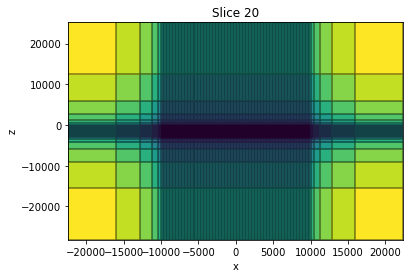

In [12]:
fig, ax = plt.subplots(1, 1)
mesh.plotSlice(np.log10(mesh.vol), normal='y', grid=True, ax=ax)
# ax.set_xlim([-10000, 10000])
# ax.set_ylim([-4000, 100])

## empymod solution

In [13]:
np.flipud(np.array(res1d))

array([1.e+00, 1.e+08])

In [14]:
rec_X, rec_Y = np.meshgrid(rec_x, rec_y)

epm_1d = empymod.bipole(
    [*src], [rec_X.ravel(), rec_Y.ravel(), rec_z, 0, 0], depth,
    np.flipud(np.array(res1d)), freq, aniso=np.flipud(np.array(aniso)), srcpts=5, strength=strength,
    verb=3, htarg={'pts_per_dec': -1}
).reshape(rec_x.size, rec_y.size, order='F')


:: empymod START  ::  v2.0.0

   depth       [m] :  0
   res     [Ohm.m] :  1 1E+08
   aniso       [-] :  2 1
   epermH      [-] :  1 1
   epermV      [-] :  1 1
   mpermH      [-] :  1 1
   mpermV      [-] :  1 1
   direct field    :  Comp. in wavenumber domain
   frequency  [Hz] :  0.1
   Hankel          :  DLF (Fast Hankel Transform)
     > Filter      :  Key 201 (2009)
     > DLF type    :  Lagged Convolution
   Loop over       :  Frequencies
   Source(s)       :  1 bipole(s)
     > intpts      :  5
     > length  [m] :  400
     > strength[A] :  800
     > x_c     [m] :  0
     > y_c     [m] :  0
     > z_c     [m] :  -200
     > azimuth [°] :  0
     > dip     [°] :  0
   Receiver(s)     :  303 dipole(s)
     > x       [m] :  -10000 - 10000 : 303  [min-max; #]
     > y       [m] :  -300 - 300 : 303  [min-max; #]
     > z       [m] :  -600
     > azimuth [°] :  0
     > dip     [°] :  0
   Required ab's   :  11
* WARNING :: Offsets < 0.001 m are set to 0.001 m!

:: empymod END; r

### put the model on the computational mesh

In [15]:
rhoh_back = res1d[0]*np.ones(mesh.nC)
rhov_back = res1d[0]*np.ones(mesh.nC)

In [63]:
for r, a, d in zip(res1d[1:], aniso[1:], depth):
    print(r, a, d)
    inds = mesh.gridCC[:, 2] <= d + dz/2
    rhoh_back[inds] = r
    rhov_back[inds] = r*a**2

1 2 0.0


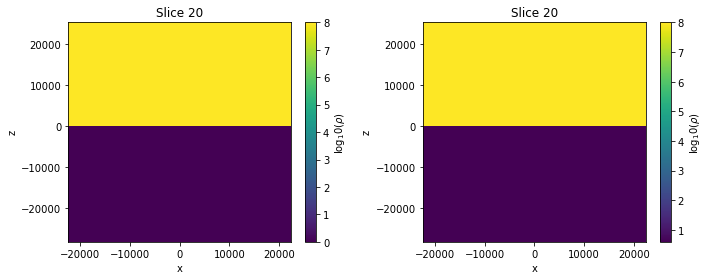

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

for a, m in zip(ax.flatten(), [rhoh_back, rhov_back]):
    cb = plt.colorbar(
        mesh.plotSlice(np.log10(m), ax=a, normal='Y')[0], ax=a
    )
    cb.set_label("log$_10$($\\rho$)")
#     a.set_xlim(domain_x*np.r_[-1, 1])
#     a.set_ylim([-4000, 100])

plt.tight_layout()

In [65]:
rho_back = np.vstack([rhoh_back, rhoh_back, rhov_back]).T

## set up the frequency domain simulation

In [66]:
rx_re = fdem.receivers.Point_e(locations=rx_locs, orientation="x", component="real")
rx_im = fdem.receivers.Point_e(locations=rx_locs, orientation="x", component="imag")

In [67]:
print(np.unique(mesh.gridEx[:, 1]))

[-15400.  -9000.  -5800.  -4200.  -3400.  -3000.  -2800.  -2600.  -2400.
  -2200.  -2000.  -1800.  -1600.  -1400.  -1200.  -1000.   -800.   -600.
   -400.   -200.      0.    200.    400.    600.    800.   1000.   1200.
   1400.   1600.   1800.   2000.   2200.   2400.   2600.   2800.   3000.
   3400.   4200.   5800.   9000.  15400.]


In [68]:
src_x = np.zeros(mesh.nEx, dtype=complex)
src_inds = (
    (mesh.gridEx[:, 0] >= src[0] - 1) & (mesh.gridEx[:, 0] <= src[1] + 1) &
    (mesh.gridEx[:, 1] >= src[2] - 1) & (mesh.gridEx[:, 1] <= src[3] + 1) &
    (mesh.gridEx[:, 2] >= src[4] - 1) & (mesh.gridEx[:, 2] <= src[5] + 1) 
)
src_x[src_inds] = 1
print(src_inds.nonzero())

src_vec = (
    strength * mesh.edge * 
    np.hstack([src_x, np.zeros(mesh.nEy, dtype=complex), np.zeros(mesh.nEz, dtype=complex)])
)
    
source = fdem.sources.RawVec_e(s_e=src_vec, freq=freq, receiver_list=[rx_re, rx_im])

(array([92454, 92455]),)


In [69]:
survey = fdem.Survey([source])

In [70]:
sim_back = fdem.Simulation3DElectricField(mesh=mesh, solver=Pardiso, survey=survey, sigmaMap=maps.IdentityMap(mesh))


In [71]:
rho_back

array([[1.e+00, 1.e+00, 4.e+00],
       [1.e+00, 1.e+00, 4.e+00],
       [1.e+00, 1.e+00, 4.e+00],
       ...,
       [1.e+08, 1.e+08, 1.e+08],
       [1.e+08, 1.e+08, 1.e+08],
       [1.e+08, 1.e+08, 1.e+08]])

In [72]:
%%time
mem_back = %memit -o fields_back = sim_back.fields(1./rho_back)
ram_back = f"{(mem_back.mem_usage[0] - mem_back.baseline)/1024:.3f} GiB"
print(f"memory usage: {ram_back}")

peak memory: 6269.55 MiB, increment: 6048.08 MiB
memory usage: 5.906 GiB
CPU times: user 6min 23s, sys: 21.9 s, total: 6min 45s
Wall time: 2min 13s


In [73]:
d_back = sim_back.dpred(1./rho_back, f=fields_back)


In [74]:
def get_data_lines(fields):
    
    data = []
    
    x_inds = (mesh.gridEx[:, 0] >= rec_x.min() - 1) & (mesh.gridEx[:, 0] <= rec_x.max() + 1)
    z_inds = (mesh.gridEx[:, 2] >= rec_z - 1) & (mesh.gridEx[:, 2] <= rec_z + 1)
    
    for y in rec_y: 
        y_inds = (mesh.gridEx[:, 1] >= y - 1) & (mesh.gridEx[:, 1] <= y + 1)
        inds_x = x_inds & y_inds & z_inds
        inds = np.hstack([inds_x, np.zeros(mesh.nEy, dtype=bool), np.zeros(mesh.nEz, dtype=bool) ])
        
        data.append(fields[:, "e"][inds])
    
    x = mesh.gridEx[inds_x, 0]
    return x, data   

In [75]:
x, data_back = get_data_lines(fields_back)

In [76]:
# reshape data to desired shape

def get_data_lines(data): 
    d_re = data[:rx_locs.shape[0]]
    d_im = data[rx_locs.shape[0]:]

    d_line1 = np.vstack([d_re[:101], d_im[:101]]).T
    d_line2 = np.vstack([d_re[101:202], d_im[101:202]]).T
    d_line3 = np.vstack([d_re[202:], d_im[202:]]).T
    
    return [d_line1, d_line2, d_line3]

data_back_lines = get_data_lines(d_back)


In [77]:
def get_pos_neg(resp, off, min_off):
    """Separate positive and negative values, enforce min_off."""
    resp_pos = np.array([x if x > 0 else np.nan for x in resp])
    resp_neg = np.array([-x if x < 0 else np.nan for x in resp])

    resp_pos[off < min_offset] = np.nan
    resp_neg[off < min_offset] = np.nan

    return resp_pos, resp_neg

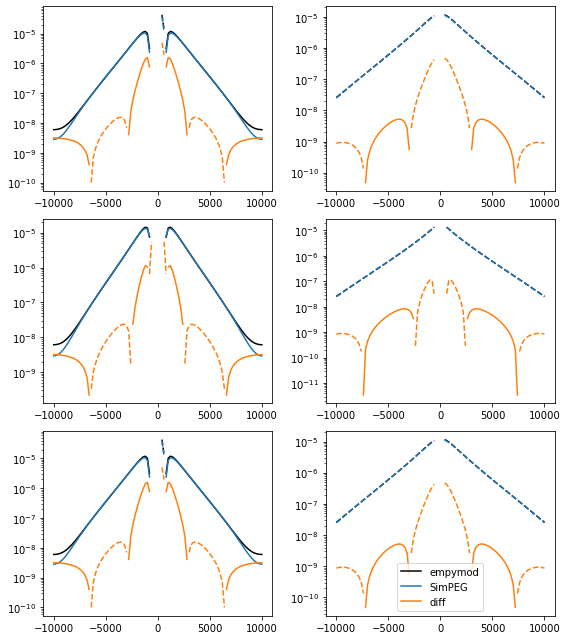

In [78]:
fig, ax = plt.subplots(3, 2, figsize=(8, 9))

# for i, d in enumerate(data_back):
#     for j, comp in enumerate(["real", "imag"]):
#         ax[i, j].semilogy(x, getattr(d, comp), "C1-")
#         ax[i, j].semilogy(x, -getattr(d, comp), "C1--")

for i, d in enumerate(data_back_lines):
    y = rec_y[i]
    off = np.sqrt(rec_x**2 + y**2)
    min_offset = 500
    for j, comp in enumerate(["real", "imag"]):
        resp_pos, resp_neg = get_pos_neg(getattr(epm_1d[:, i], comp), off, min_offset)
        ax[i, j].plot(rec_x, resp_pos, 'k-', label='empymod')
        ax[i, j].plot(rec_x, resp_neg, 'k--')
        
        simpeg_pos, simpeg_neg = get_pos_neg(d[:, j], off, min_offset)
        ax[i, j].semilogy(rec_x, simpeg_pos, "C0-", label="SimPEG")
        ax[i, j].semilogy(rec_x, simpeg_neg, "C0--")
        
        diff_pos, diff_neg = get_pos_neg(getattr(epm_1d[:, i], comp) - d[:, j], off, min_offset)
        ax[i, j].semilogy(rec_x, diff_pos, "C1-", label="diff")
        ax[i, j].semilogy(rec_x, diff_neg, "C1--")

plt.legend()
plt.tight_layout()

In [31]:
# Calculate error
error = {}
spg_data = np.vstack([d[:, 0] + 1j*d[:, 1] for d in data_back_lines]).T
for name, data in zip(['SimPEG'], [spg_data]):
    rerr = np.clip(100*abs((epm_1d.real-data.real)/epm_1d.real), 0.01, 100)
    ierr = np.clip(100*abs((epm_1d.imag-data.imag)/epm_1d.imag), 0.01, 100)
    error[name] = rerr + 1j*ierr

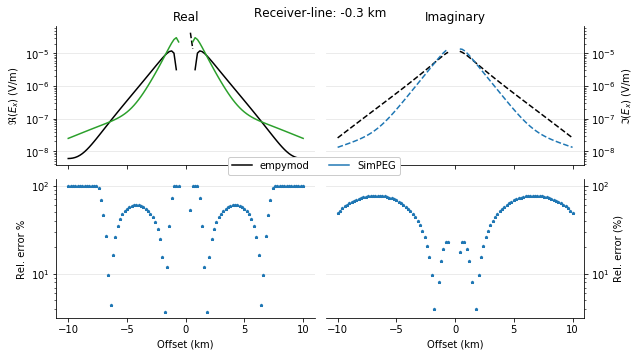

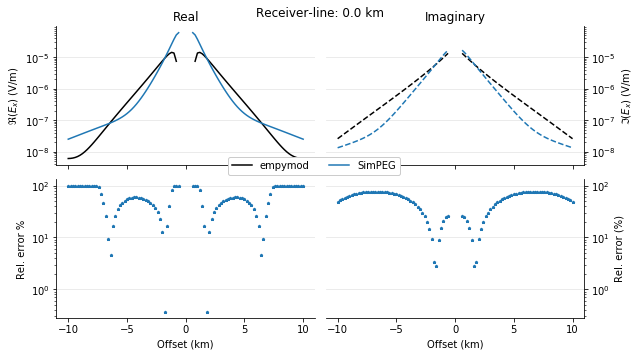

In [32]:
marker = ['*', 'v', '^', 'o']
min_offset = 500

for iy, y in enumerate(rec_y[:2]):
    
    # Get offset
    off = np.sqrt(rec_x**2 + y**2)

    plt.figure(figsize=(9, 5))

    # # Real
    ax1 = plt.subplot(221)
    plt.title('Real')

    resp_pos, resp_neg = get_pos_neg(epm_1d[:, iy].real, off, min_offset)
    plt.plot(rec_x/1e3, resp_pos, 'k-', label='empymod')
    plt.plot(rec_x/1e3, resp_neg, 'k--')
    
    resp_pos, resp_neg = get_pos_neg(spg_data[:, iy].real, off, min_offset)
    plt.plot(rec_x/1e3, resp_pos, f'C{i}-', ms=3, label="SimPEG")
    plt.plot(rec_x/1e3, resp_neg, f'C{i}--', ms=3)


    plt.ylabel(r'$\Re(E_x)$ (V/m)')
    ax1.set_xticklabels([])
    plt.grid(axis='y', c='0.9')


    # # Real Error
    ax2 = plt.subplot(223)

    for i, name in enumerate(error.keys()):
        error[name][off < min_offset, iy] = np.nan + 1j*np.nan
        plt.plot(rec_x/1e3, error[name][:, iy].real, f'C{i}{marker[i]}', ms=3)

    plt.yscale('log')
    plt.xlim(ax1.get_xlim())
    plt.ylabel('Rel. error %')
#     plt.ylim([8e-3, 120])
#     plt.yticks([0.01, 0.1, 1, 10, 100], ('0.01', '0.1', '1', '10', '100'))
    plt.grid(axis='y', c='0.9')
    plt.xlabel('Offset (km)')


    # # Imaginary
    ax3 = plt.subplot(222, sharey=ax1)
    plt.title('Imaginary')

    resp_pos, resp_neg = get_pos_neg(epm_1d[:, iy].imag, off, min_offset)
    plt.plot(rec_x/1e3, resp_pos, 'k-', label='empymod')
    plt.plot(rec_x/1e3, resp_neg, 'k--')
    
    resp_pos, resp_neg = get_pos_neg(spg_data[:, iy].imag, off, min_offset)
    plt.plot(rec_x/1e3, resp_pos, f'C0-', ms=3, label="SimPEG")
    plt.plot(rec_x/1e3, resp_neg, f'C0--', ms=3)
    
    plt.yscale('log')
    plt.ylabel(r'$\Im(E_x)$ (V/m)')

    ax3.set_xticklabels([])
    ax3.yaxis.tick_right()
    ax3.yaxis.set_label_position("right")
    plt.grid(axis='y', c='0.9')


    # # Imaginary Error
    ax4 = plt.subplot(224, sharey=ax2)

    for i, name in enumerate(error.keys()):
        plt.plot(rec_x/1e3, error[name][:, iy].imag, f'C{i}{marker[i]}', ms=3)

    # Legend
    plt.plot(0, -1, 'k', label='empymod')
    for i, name in enumerate(error.keys()):
        plt.plot(0, -1, f'C{i}', label=name)
        
    plt.yscale('log')
    plt.xlim(ax1.get_xlim())
    plt.xlabel('Offset (km)')
    plt.ylabel('Rel. error (%)')
#     plt.ylim([8e-3, 120])
#     plt.yticks([0.01, 0.1, 1, 10, 100], ('0.01', '0.1', '1', '10', '100'))
    ax4.yaxis.tick_right()
    ax4.yaxis.set_label_position("right")
    plt.grid(axis='y', c='0.9')

    # Switch off spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.spines['left'].set_visible(False)

    plt.tight_layout()
    plt.legend(loc=2, ncol=2, bbox_to_anchor=(-0.4, 1.2), framealpha=1)
    
    #plt.savefig(f'../manuscript/figures/results-layered-{int(y/1e3)}.pdf', bbox_inches='tight')
    plt.suptitle(f'Receiver-line: {y/1e3} km')
    plt.show()

In [33]:
from matplotlib.colors import LogNorm

Text(0.5, 1.0, '0.0')

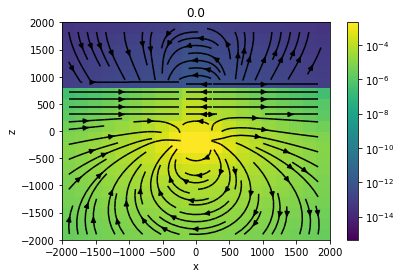

In [34]:
fig, ax = plt.subplots(1, 1)

ind = 20
xlim = 2000*np.r_[-1, 1]
ylim = 2000*np.r_[-1, 1]

normal="y"

plt.colorbar(mesh.plotSlice(
    fields_back[:, "j"].real, view="vec", vType="E", pcolorOpts={"norm": LogNorm()},
    ax=ax, ind=ind, range_x=xlim, range_y=ylim, normal=normal
)[0], ax=ax)

ax.set_title(getattr(mesh, f"vectorN{normal}")[ind])


In [35]:
src

array([-200.,  200.,    0.,    0., -200., -200.])